# Week 2:  The Iris dataset, Naive Bayes, and k-Nearest Neighbors

## Iris Dataset

We will start with a classic dataset due to R.A. Fischer that invovles classifying Iris flowers from measurements of their flowers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.stats import describe
%matplotlib inline

Load the Iris dataset from `sklearn`.  Divide the data into the features (X) and targets (Y).

In [2]:
iris = datasets.load_iris()
X = iris.data
Y = iris.target

Look at the shape of the datasets.

In [3]:
print(f'The shape of the features is {X.shape}.')
print(f'The features being used are:\n{iris.feature_names}')
print(f'The shape of the targets is {Y.shape}.')
print(f'The targets correspond to the following flowers:\n {iris.target_names}')

The shape of the features is (150, 4).
The features being used are:
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
The shape of the targets is (150,).
The targets correspond to the following flowers:
 ['setosa' 'versicolor' 'virginica']


Examine the targets and see what range of values we have to worry about.

In [4]:
print(Y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


Provide some summary statistics of the data features to examine what they are like.

In [5]:
for name, feature in zip(iris.feature_names, np.arange(X.shape[1])):
    summary_stats = describe(X[:,feature])
    print(f'The summary statistiscs of {name} is \n{summary_stats}')

The summary statistiscs of sepal length (cm) is 
DescribeResult(nobs=150, minmax=(4.3, 7.9), mean=5.843333333333334, variance=0.6856935123042507, skewness=0.3117530585022963, kurtosis=-0.5735679489249765)
The summary statistiscs of sepal width (cm) is 
DescribeResult(nobs=150, minmax=(2.0, 4.4), mean=3.0573333333333337, variance=0.189979418344519, skewness=0.31576710633893473, kurtosis=0.18097631752246768)
The summary statistiscs of petal length (cm) is 
DescribeResult(nobs=150, minmax=(1.0, 6.9), mean=3.7580000000000005, variance=3.116277852348993, skewness=-0.2721276664567214, kurtosis=-1.3955358863990055)
The summary statistiscs of petal width (cm) is 
DescribeResult(nobs=150, minmax=(0.1, 2.5), mean=1.1993333333333336, variance=0.5810062639821029, skewness=-0.10193420656560036, kurtosis=-1.336067405231553)


We see that the values are all roughly the same , with feature 1 having the greatest values.  The variance of the third feature is the greatest.  Now we plot the data in histograms to see what the distributions look like.

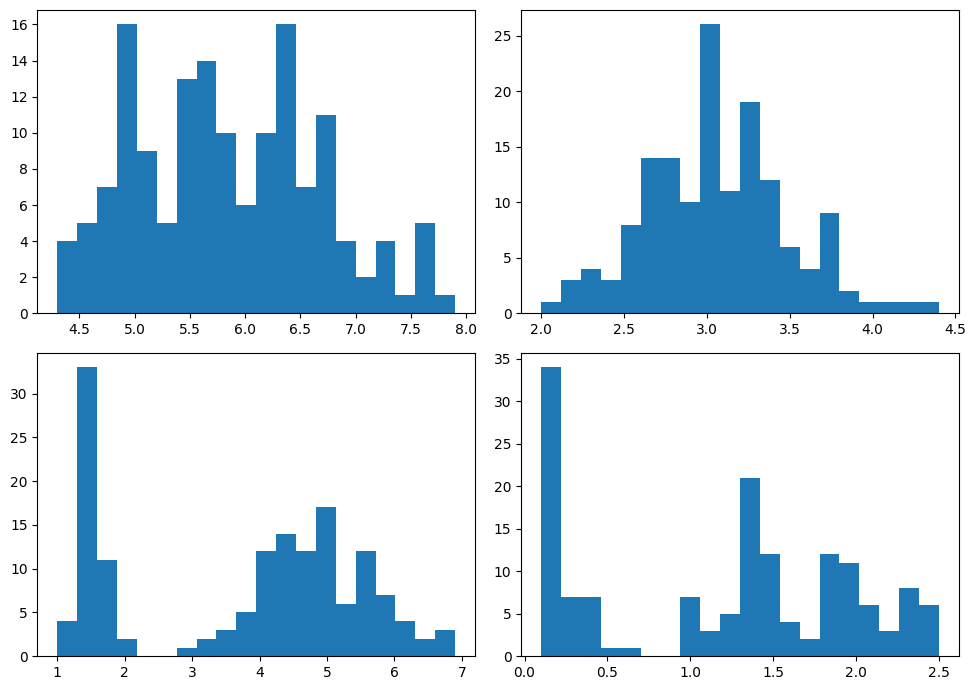

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,7))

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].hist(X[:,(i*2)+j], bins=20)

fig.tight_layout()
plt.show()

The distributions are roughly normal for our first two features and more bimodal for the other two features.

Since the lower two have a more bimodal distribution, we will use the first two features for our predictions.

In [7]:
X = X[:,:2]

## Naive Bayes

We will now train a model to predict our data targets from our features.  To do this we will use `sklearn` and several useful utilities.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from sklearn.naive_bayes import GaussianNB

First, we split our data between a training set and a hold-out test set.  We also shuffle our data:  this is important for ERM since we need to ensure our training data is i.i.d..  We choose a split size of 80/20 for the data.

In [9]:
X_tr, X_te, Y_tr, Y_te = train_test_split(X, Y, test_size=0.2, random_state=123, shuffle=True)

Second, we use a `GaussianNB` model since we our feature data is continuous.  This model assumes a likelihood from our targets to our features that is normally distributed $x \sim \mathcal{N}(x_{i} | \mu, \sigma^{2})$.  The `fit` method finds the mean and variances of these likelihoods.  We can set the prior parameter for this model, but here we defer to the frequencies in the training data.

In [10]:
# Initialize the model
nb_model = GaussianNB()

# Train the model with fit
nb_model.fit(X=X_tr, y=Y_tr)

# Examine the model parameters
print(nb_model.get_params())

{'priors': None, 'var_smoothing': 1e-09}


We can now see how well our model predicts specific samples from our training data:

In [11]:
sample = X_tr[0].reshape(1,-1)
y_hat = nb_model.predict(sample)

print(f'The prediction of our model on {X_tr[0,:]} is {y_hat}, while the true target is {Y_tr[0]}.')

The prediction of our model on [7.4 2.8] is [2], while the true target is 2.


This is good!  We got a good prediction.  Now lets see what the probabilities our model assigns to this particular target.

In [12]:
probs = nb_model.predict_proba(sample)
print(f'The probabilities the model assigns to the various classes is {probs}.')

The probabilities the model assigns to the various classes is [[2.09609355e-12 7.04094478e-02 9.29590552e-01]].


Looks like our model is very confident about this particular sample.  Lets see how the model does on the whole training data with `accuracy_score` and built-in `score` method.

In [13]:
# Get predictions
y_hats = nb_model.predict(X=X_tr)

print(y_hats)

# Use the sklearn accuracy_score method
train_acc = accuracy_score(y_true=Y_tr, y_pred=y_hats)

print(f'The average accuracy of the model is {train_acc}.')

# Use the built in method.
train_acc = nb_model.score(X=X_tr, y=Y_tr)

print(f'The average accuracy of the model is {train_acc}.')

[2 1 0 0 1 1 2 0 0 1 1 0 2 2 1 1 2 1 0 0 2 0 0 2 1 1 1 1 2 2 1 2 1 0 0 1 2
 2 2 0 2 1 1 0 2 2 2 0 1 1 0 0 1 2 2 0 0 1 0 1 2 0 2 0 0 2 0 0 2 2 2 1 1 0
 0 2 1 0 0 1 2 1 2 2 1 1 2 0 0 1 2 2 2 2 0 1 0 1 1 0 1 2 1 2 1 0 1 0 2 1 1
 1 1 1 1 0 1 1 1 2]
The average accuracy of the model is 0.7666666666666667.
The average accuracy of the model is 0.7666666666666667.


We have a very high accuracy!  Let's see how it does on a loss function using the cross entropy loss (more on this next week).

In [14]:
# We use the probabilities to compute the loss
y_probs = nb_model.predict_proba(X=X_tr)
loss = log_loss(y_true=Y_tr, y_pred=y_probs)

print(f'The log loss is {loss}.')

The log loss is 0.4474649394427664.


And let's look at the ROC AUC score for each label against the rest.

In [15]:
auc = roc_auc_score(y_true=Y_tr, y_score=y_probs, multi_class='ovo')

print(f'The AUC ROC score is {auc}.')

The AUC ROC score is 0.9187640437640437.


Of course, we need to evaluate how well our model does on the hold-out test set to check for overfitting.  So we compute all of the metrics on our hold-out test set `X_te` and `Y_te`.

In [16]:
# Get predictions and probabilities on hold-out test set
y_hats = nb_model.predict(X=X_te)
y_probs = nb_model.predict_proba(X=X_te)

# Compute scores
test_acc = accuracy_score(y_true=Y_te, y_pred=y_hats)
test_loss = log_loss(y_true=Y_te, y_pred=y_probs)
test_auc = roc_auc_score(y_true=Y_te, y_score=y_probs, multi_class='ovo')

print(f'The scores on the test set are: \nAccuracy: {test_acc}\nLoss: {test_loss}\nAUC ROC: {test_auc}')

The scores on the test set are: 
Accuracy: 0.8333333333333334
Loss: 0.3431424138247936
AUC ROC: 0.9722222222222222


We see good performance across the metrics on the hold-out test set, meaning our model has not overfitted on the training data.

Now, let's see the effect of the prior on our prediction.  Let's suppose our prior thinks the first class is 8 times more likely than the other two classes so that we have priors of $0.8, 0.1, 0.1$.

In [17]:
# Set the priors
prior = np.array([0.8, 0.1, 0.1])

# Iniitialize model
nb_model = GaussianNB(priors=prior)

# Fit the model
nb_model.fit(X=X_tr, y=Y_tr)

# Evaluate model on the training data
y_hats = nb_model.predict(X=X_tr)
y_probs = nb_model.predict_proba(X=X_tr)
train_acc = accuracy_score(y_true=Y_tr, y_pred=y_hats)
train_loss = log_loss(y_true=Y_tr, y_pred=y_probs)
train_auc = roc_auc_score(y_true=Y_tr, y_score=y_probs, multi_class='ovo')

print(f'The scores on the train set are: \nAccuracy: {train_acc}\nLoss: {train_loss}\nAUC ROC: {train_auc}')

# Evaluate model on the test data
y_hats = nb_model.predict(X=X_te)
y_probs = nb_model.predict_proba(X=X_te)
test_acc = accuracy_score(y_true=Y_te, y_pred=y_hats)
test_loss = log_loss(y_true=Y_te, y_pred=y_probs)
test_auc = roc_auc_score(y_true=Y_te, y_score=y_probs, multi_class='ovo')

print(f'The scores on the test set are: \nAccuracy: {test_acc}\nLoss: {test_loss}\nAUC ROC: {test_auc}')

The scores on the train set are: 
Accuracy: 0.7166666666666667
Loss: 0.5226876143052499
AUC ROC: 0.9095529095529096
The scores on the test set are: 
Accuracy: 0.7666666666666667
Loss: 0.3850857432680239
AUC ROC: 0.9494949494949495


We seem to have done worse here with our prior.  So the default, uniform prior seems to work best here on this data.

## k-Nearest Neighbors

Now we do the k-Nearest Neighbors algorithm to do the same task on Iris.  We import the model again from `sklearn`.

In [18]:
from sklearn.neighbors import KNeighborsClassifier

We will use the `KNeighborsClassifier` that allows several varieties of k-Nearest Neighbor (kNN).  Here we will use the kNN that uniformly weights neighbors and then assigns the label based on the closest by Euclidean distance.  We choose the closest neighbors, so our algorithm is a 1NN.

In [19]:
# Initialize the model
knn_model_1 = KNeighborsClassifier(n_neighbors=1, metric='euclidean')

# Fit the model
knn_model_1.fit(X=X_tr, y=Y_tr)

KNeighborsClassifier(metric='euclidean', n_neighbors=1)

Now we use it to make a prediction as before for both a sample and its probabilities.

In [20]:
sample = X_tr[0].reshape(1,-1)
y_hat = knn_model_1.predict(sample)
y_prob = knn_model_1.predict_proba(sample)

print(f'The prediction of our model on {X_tr[0,:]} is {y_hat}, while the true target is {Y_tr[0]}. \nThe model assigns probabilities {y_prob}')

The prediction of our model on [7.4 2.8] is [2], while the true target is 2. 
The model assigns probabilities [[0. 0. 1.]]


Very good on this sample.  So let's see how well it does on the whole training data.

In [21]:
# Get predictions
y_hats = knn_model_1.predict(X=X_tr)
y_probs = knn_model_1.predict_proba(X=X_tr)

# Get performance on the training data.
train_acc = accuracy_score(y_true=Y_tr, y_pred=y_hats)
train_loss = log_loss(y_true=Y_tr, y_pred=y_probs)
train_auc = roc_auc_score(y_true=Y_tr, y_score=y_probs, multi_class='ovo')

print(f'The scores on the train set are: \nAccuracy: {train_acc}\nLoss: {train_loss}\nAUC ROC: {train_auc}')

The scores on the train set are: 
Accuracy: 0.9166666666666666
Loss: 3.0036377824264293
AUC ROC: 0.9380827505827506


We did very well on the training data.  Let's see how we do on the test data.

In [22]:
# Get predictions
y_hats = knn_model_1.predict(X=X_te)
y_probs = knn_model_1.predict_proba(X=X_te)

# Get performance on the training data.
test_acc = accuracy_score(y_true=Y_te, y_pred=y_hats)
test_loss = log_loss(y_true=Y_te, y_pred=y_probs)
test_auc = roc_auc_score(y_true=Y_te, y_score=y_probs, multi_class='ovo')

print(f'The scores on the test set are: \nAccuracy: {test_acc}\nLoss: {test_loss}\nAUC ROC: {test_auc}')

The scores on the test set are: 
Accuracy: 0.8
Loss: 7.2087306778234295
AUC ROC: 0.8446969696969697


We did noticably worse on the test data this time.  Now, let's see what happens when we increase the k to 30.  So we are doing 30NN.

In [23]:
# Initialize the model
knn_model_30 = KNeighborsClassifier(n_neighbors=30, metric='euclidean')

# Fit the model
knn_model_30.fit(X=X_tr, y=Y_tr)

# Get predictions
y_hats = knn_model_30.predict(X=X_tr)
y_probs = knn_model_30.predict_proba(X=X_tr)

# Get performance on the training data.
train_acc = accuracy_score(y_true=Y_tr, y_pred=y_hats)
train_loss = log_loss(y_true=Y_tr, y_pred=y_probs)
train_auc = roc_auc_score(y_true=Y_tr, y_score=y_probs, multi_class='ovo')

print(f'The scores on the train set are: \nAccuracy: {train_acc}\nLoss: {train_loss}\nAUC ROC: {train_auc}')

# Get predictions
y_hats = knn_model_30.predict(X=X_te)
y_probs = knn_model_30.predict_proba(X=X_te)

# Get performance on the training data.
test_acc = accuracy_score(y_true=Y_te, y_pred=y_hats)
test_loss = log_loss(y_true=Y_te, y_pred=y_probs)
test_auc = roc_auc_score(y_true=Y_te, y_score=y_probs, multi_class='ovo')

print(f'The scores on the test set are: \nAccuracy: {test_acc}\nLoss: {test_loss}\nAUC ROC: {test_auc}')

The scores on the train set are: 
Accuracy: 0.7833333333333333
Loss: 0.4594443058897536
AUC ROC: 0.9223366723366723
The scores on the test set are: 
Accuracy: 0.8333333333333334
Loss: 0.40296702194672346
AUC ROC: 0.9482323232323232


We did worse on the training data but have higher AUC scores on the test data as well as lower loss.  Let's compare our decision boundary.

In [24]:
from sklearn.inspection import DecisionBoundaryDisplay

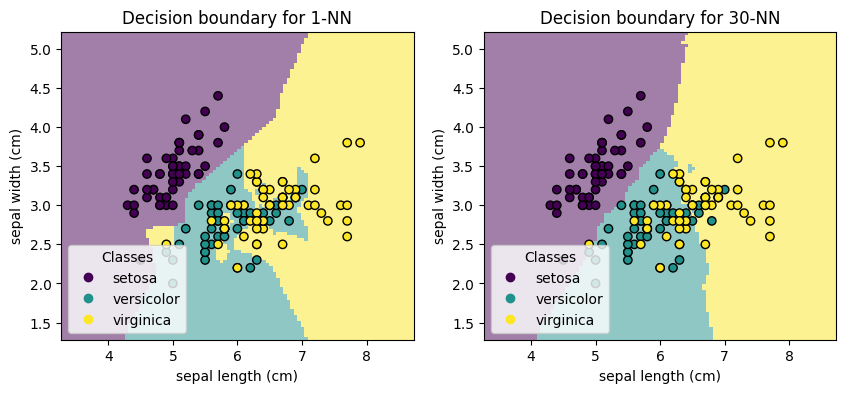

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
models = [knn_model_1, knn_model_30]

for m, i in zip(models, np.arange(axs.shape[0])):
    disp = DecisionBoundaryDisplay.from_estimator(
        m,
        X_te,
        response_method='predict',
        plot_method='pcolormesh',
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[1],
        shading='auto',
        alpha=0.5,
        ax=axs[i]
    )
    scatter = disp.ax_.scatter(X[:,0], X[:,1], c=Y, edgecolors='k')
    disp.ax_.legend(
        scatter.legend_elements()[0],
        iris.target_names,
        loc='lower left',
        title='Classes'
    )

    k = m.get_params()['n_neighbors']
    _ = disp.ax_.set_title(
        f'Decision boundary for {k}-NN'
    )